In [76]:
import matplotlib
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Liberation Serif'
# plt.rcParams['font.family'] = 'Liberation Serif Bold'
from matplotlib.font_manager import FontProperties
print("Current font:", FontProperties().get_name())

Current font: Liberation Serif


    
┌───────────────────────────────────────────────────────┐
│   Input Layer                                         |
│   U₀, ω Original input                                │
└───────────────────────────────────────────────────────┘
           ↓
┌───────────────────────────────────────────────────────┐
│ Feature Augmentation Layer                            │
│ Operation: Add ω² term → [U₀, ω, ω²]                  │
└───────────────────────────────────────────────────────┘
           ↓
┌───────────────────────────────────────────────────────┐
│ Attention Gate                                        │
│ Operation: α = sigmoid(-γ|M|)                         │
│ Output: X_aug * α (Feature weighting)                 │
└───────────────────────────────────────────────────────┘
           ↓
┌───────────────────────────────────────────────────────┐
│ Hidden Layer 1 (100 neurons)                          │
│ Activation: ReLU(·) = max(0, ·)                       │
└───────────────────────────────────────────────────────┘
           ↓
┌───────────────────────────────────────────────────────┐
│ Hidden Layer 2 (50 neurons)                           │
│ Activation: ReLU                                      │
└───────────────────────────────────────────────────────┘
           ↓
┌───────────────────────────────────────────────────────┐
│ Output Layer                                          │
│ Output: Predicted torque M_pred (Linear output)       │
└───────────────────────────────────────────────────────┘
           ↓
┌───────────────────────────────────────────────────────┐
│ Loss Function                                         │
│ L = MSE(M_pred, M_true) + λ||θ||²                     │
└───────────────────────────────────────────────────────┘


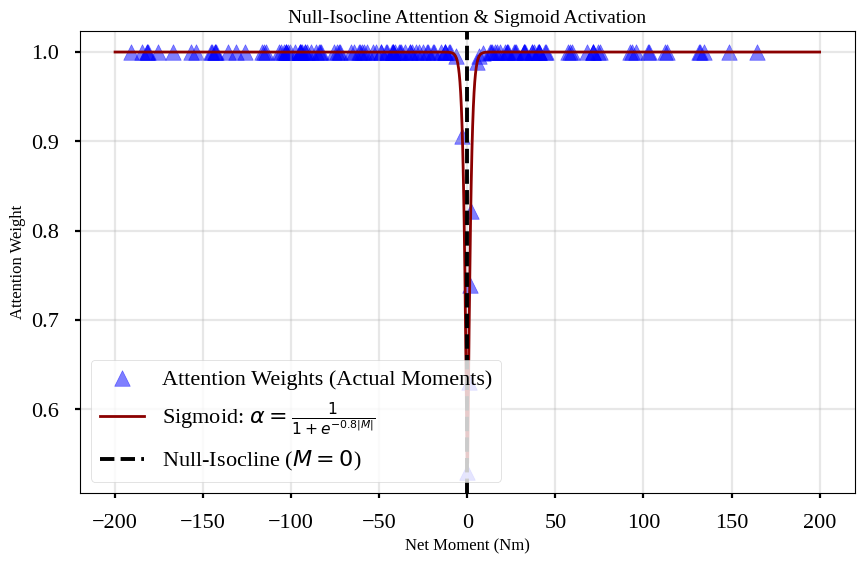

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Actual moment matrix
moment_matrix = np.array([
    [-60.98, -41.95, -92.01, -94.84, -102.69, -143.16, -182.06],
    [-53.71, -56.73, -104.13, -106.81, -114.30, -154.24, -191.21],
    [-42.25, -45.38, -95.08, -97.85, -105.60, -145.53, -184.44],
    [-38.79, -41.95, -92.01, -94.85, -102.69, -143.16, -182.06],
    [-37.90, -41.05, -91.21, -94.02, -101.89, -142.51, -181.42],
    [-29.40, -32.52, -83.32, -86.21, -94.21, -135.74, -175.57],
    [-19.46, -22.47, -73.03, -75.93, -84.03, -126.38, -167.22],
    [ -9.88, -12.52, -61.37, -64.29, -72.48, -115.37, -156.86],
    [ -0.15,  -2.83, -48.74, -51.61, -59.72, -102.88, -144.96],
    [  8.77,   6.79, -35.68, -38.41, -46.28, -88.99, -131.43],
    [ 15.85,  13.64, -22.63, -25.12, -32.57, -74.07, -116.54],
    [ 22.31,  21.21, -10.31, -12.94, -19.19, -58.62, -100.43],
    [ 27.50,  26.89,   1.91,   0.67,  -6.65, -42.87, -83.52],
    [ 32.33,  32.01,  13.98,  12.68,   5.59, -27.52, -66.25],
    [ 36.73,  36.67,  22.87,  22.47,  18.38, -12.79, -48.82],
    [ 40.79,  40.93,  32.97,  31.92,  26.51,   1.30, -31.63],
    [ 44.31,  44.72,  40.88,  40.30,  37.84,  17.07, -15.18],
    [ 58.45,  59.67,  71.17,  71.33,  71.58,  68.03,  57.29],
    [ 74.19,  75.03,  92.41,  93.31,  95.52, 102.40, 102.86],
    [112.11, 113.43, 131.28, 132.22, 134.54, 148.75, 164.40]
])

# Flatten the moment matrix
moments_flat = moment_matrix.flatten()

# Set the gamma parameter
gamma = 0.8

# Calculate attention weights
attention_weights = 1 / (1 + np.exp(-gamma * np.abs(moments_flat)))

# Generate smooth sigmoid curve
M_range = np.linspace(-200, 200, 1000)
attention_curve = 1 / (1 + np.exp(-gamma * np.abs(M_range)))

# Plotting
plt.figure(figsize=(10, 6))

# Plot actual data scatter
plt.scatter(moments_flat, attention_weights, alpha=0.5, label="Attention Weights (Actual Moments)", color="blue", marker='^')

# Plot sigmoid curve
plt.plot(M_range, attention_curve, linewidth=2, color="darkred", label=r"Sigmoid: $\alpha = \frac{1}{1 + e^{-0.8 |M|}}$")

# Add null-isocline dashed line
plt.axvline(x=0, linestyle="--", color="black", label="Null-Isocline ($M=0$)")

# Axis labels and title
plt.xlabel("Net Moment (Nm)", fontsize=12)
plt.ylabel("Attention Weight", fontsize=12)
plt.title("Null-Isocline Attention & Sigmoid Activation", fontsize=14)

# Legend and grid
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize_scalar

# -----------------------------
# 1. Define the Feature-Engineered Model
# -----------------------------
class FeatureEngineeredModel(BaseEstimator, RegressorMixin):
    def __init__(self, R=8.5, gamma=0.8, hidden_layers=(50, 25), alpha=1e-3):  # Reduced layers and nodes
        self.R = R
        self.gamma = gamma
        self.scaler = StandardScaler()
        self.model = MLPRegressor(
            hidden_layer_sizes=hidden_layers,
            activation='relu',
            alpha=alpha,            # Add regularization
            max_iter=5000,
            random_state=42,
            early_stopping=True
        )

    def _augment_features(self, X):
        U0, omega = X[:, 0], X[:, 1]
        return np.column_stack([U0, omega, U0 * omega, omega ** 2])

    def _attention_weights(self, M):
        return 1 / (1 + np.exp(-self.gamma * np.abs(M)))

    def fit(self, X, M):
        Xs = self.scaler.fit_transform(X)
        X_aug = self._augment_features(Xs)
        w = self._attention_weights(M)
        self.model.fit(X_aug * w[:, None], M)
        return self

    def predict(self, X):
        Xs = self.scaler.transform(X)
        X_aug = self._augment_features(Xs)
        return self.model.predict(X_aug)

    def optimal_TSR(self, U0_values):
        tsr_list = []
        for U0 in U0_values:
            def obj(omega):
                M_pred = self.predict(np.array([[U0, omega]]))[0]
                return abs(M_pred)
            res = minimize_scalar(obj, bounds=(0.8, 1.4), method='bounded')
            tsr_list.append(res.x * self.R / U0)
        return np.array(tsr_list)

# -----------------------------
# 2. Prepare Data and Train
# -----------------------------
R = 8.5
U0_list = np.array([0.4,0.6,0.756,0.8,0.81,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.5,3.0,4.0])
omega_list = np.array([0.8,0.817,1.055,1.067,1.1,1.26,1.4])
moment_matrix = np.array([
    [-60.98, -41.95, -92.01, -94.84, -102.69, -143.16, -182.06],
    [-53.71, -56.73, -104.13, -106.81, -114.30, -154.24, -191.21],
    [-42.25, -45.38, -95.08, -97.85, -105.60, -145.53, -184.44],
    [-38.79, -41.95, -92.01, -94.85, -102.69, -143.16, -182.06],
    [-37.90, -41.05, -91.21, -94.02, -101.89, -142.51, -181.42],
    [-29.40, -32.52, -83.32, -86.21, -94.21, -135.74, -175.57],
    [-19.46, -22.47, -73.03, -75.93, -84.03, -126.38, -167.22],
    [ -9.88, -12.52, -61.37, -64.29, -72.48, -115.37, -156.86],
    [ -0.15,  -2.83, -48.74, -51.61, -59.72, -102.88, -144.96],
    [  8.77,   6.79, -35.68, -38.41, -46.28,  -88.99, -131.43],
    [ 15.85,  13.64, -22.63, -25.12, -32.57,  -74.07, -116.54],
    [ 22.31,  21.21, -10.31, -12.94, -19.19,  -58.62, -100.43],
    [ 27.50,  26.89,   1.91,   0.67,  -6.65,  -42.87,  -83.52],
    [ 32.33,  32.01,  13.98,  12.68,   5.59,  -27.52,  -66.25],
    [ 36.73,  36.67,  22.87,  22.47,  18.38,  -12.79,  -48.82],
    [ 40.79,  40.93,  32.97,  31.92,  26.51,    1.30,  -31.63],
    [ 44.31,  44.72,  40.88,  40.30,  37.84,   17.07,  -15.18],
    [ 58.45,  59.67,  71.17,  71.33,  71.58,   68.03,   57.29],
    [ 74.19,  75.03,  92.41,  93.31,  95.52,  102.40,  102.86],
    [112.11, 113.43, 131.28, 132.22, 134.54,  148.75,  164.40]
])

# Expand the grid
U0g, ωg = np.meshgrid(U0_list, omega_list, indexing='ij')
X_train = np.column_stack([U0g.ravel(), ωg.ravel()])
y_train = moment_matrix.ravel()

# Train the model
model = FeatureEngineeredModel(R=8.5, gamma=0.8, hidden_layers=(100, 50))
model.fit(X_train, y_train)

# -----------------------------
# 3. Predict and Fit on Fine Grid
# -----------------------------
# Construct a fine grid
U0_fine = np.linspace(U0_list.min(), U0_list.max(), 200)
ω_fine = np.linspace(omega_list.min(), omega_list.max(), 200)
Uf, Wf = np.meshgrid(U0_fine, ω_fine, indexing='xy')
Xf = np.column_stack([Uf.ravel(), Wf.ravel()])

# Predict torque
Mf = model.predict(Xf).reshape(200, 200)

# Linear fit: M = a·U0 + b·ω²
# Least squares without intercept
F2 = np.column_stack([
    X_train[:, 0],           # U0
    -X_train[:, 1] ** 2      # -ω²
])
κ, β = np.linalg.lstsq(F2, y_train, rcond=None)[0]
print(f"κ = {κ:.4f}, β = {β:.4f}")

# Compute optimal TSR curve: ω_opt(U0)
TSR_opt_fine = model.optimal_TSR(U0_fine)
ω_opt_fine = TSR_opt_fine * model.R / U0_fine  # Corresponding ω


κ = 68.7725, β = 107.6905


<ipython-input-82-551fac0174b2>:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


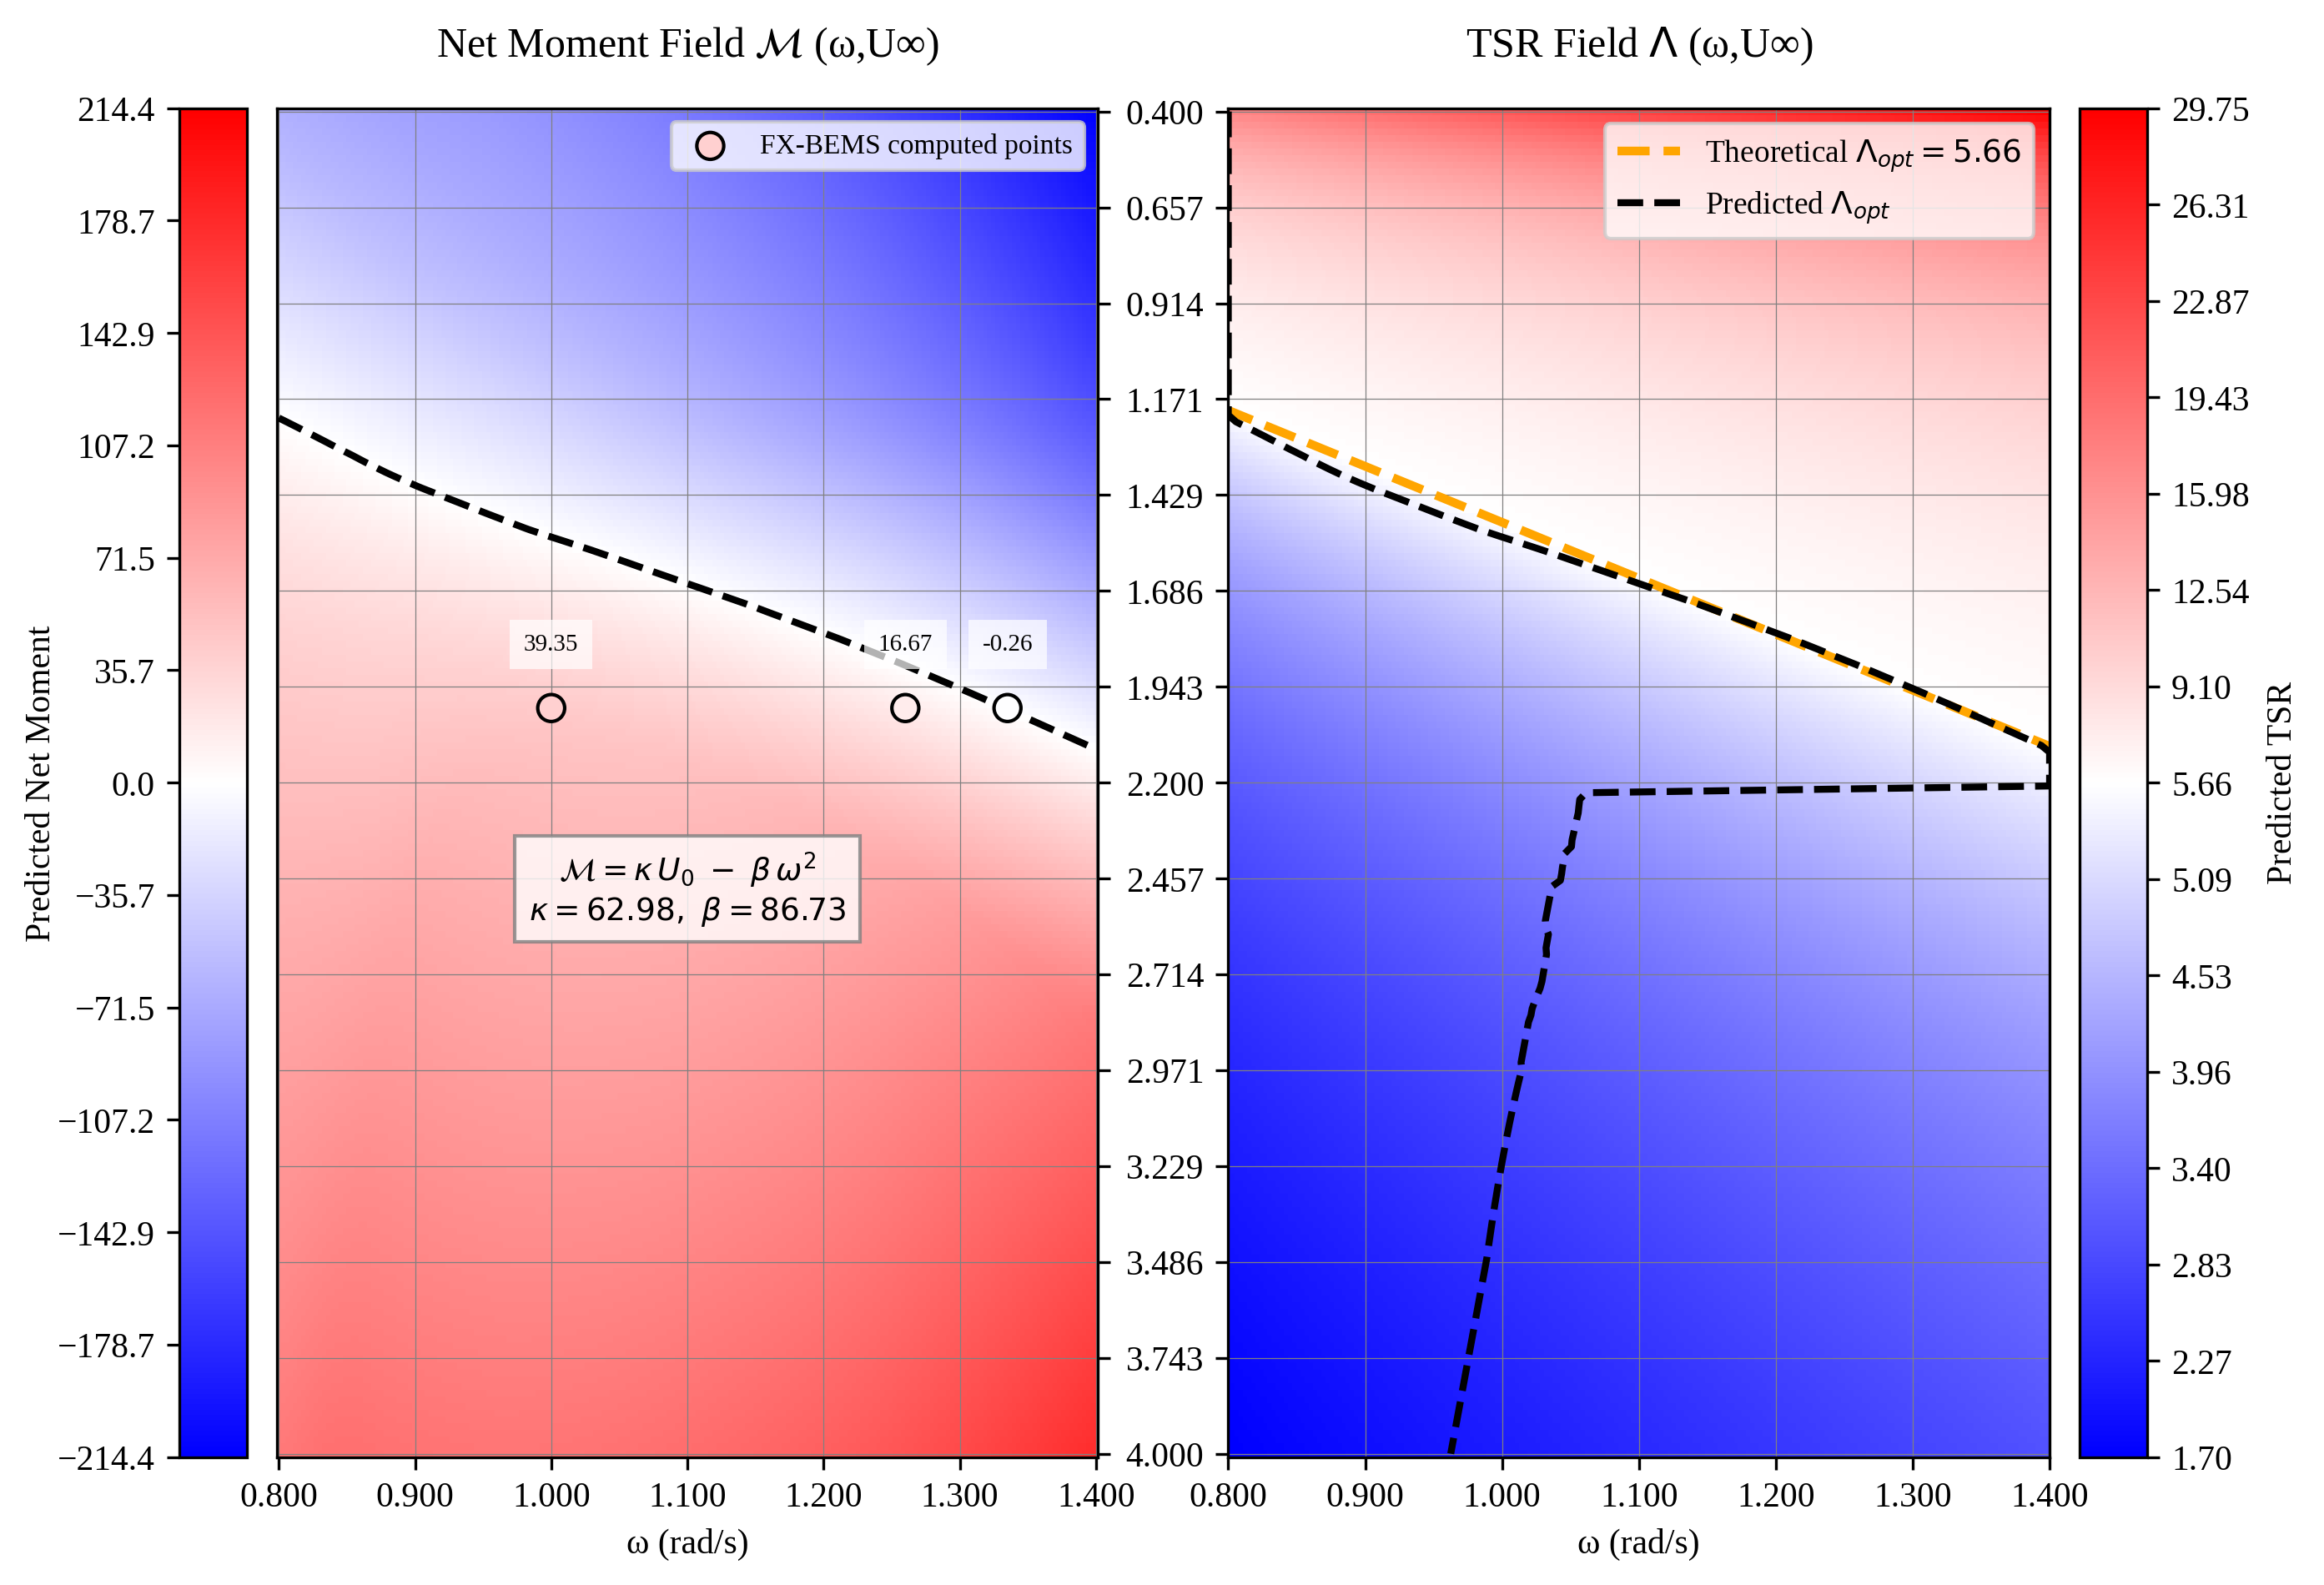

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

# —— Assume the following variables are defined and the model is trained ——
# U0_list, omega_list, R, model, cmap1, cmap2, max_abs_M

# 1. Create a dense meshgrid and make predictions
U0_dense    = np.linspace(U0_list.min(), U0_list.max(), 200)
omega_dense = np.linspace(omega_list.min(), omega_list.max(), 200)
# —— Apply clamping to ensure values stay within training range ——
U0_dense = np.clip(U0_dense, U0_list.min(), U0_list.max())
omega_dense = np.clip(omega_dense, omega_list.min(), omega_list.max())
Ωg, U0g     = np.meshgrid(omega_dense, U0_dense)
X_dense     = np.column_stack([U0g.ravel(), Ωg.ravel()])
M_pred_dense= model.predict(X_dense).reshape(U0_dense.size, omega_dense.size)
TSR_dense   = (Ωg * R) / U0g

# 2. Fit κ, β (M ≈ κ·U0·ω – β·ω²)
X_kb        = np.column_stack([X_dense[:,0], X_dense[:,1]**2])
coeffs, *_  = np.linalg.lstsq(X_kb, model.predict(X_dense), rcond=None)
kappa_hat   = coeffs[0]
beta_hat    = -coeffs[1]

# 3. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 7), gridspec_kw={'wspace':0.13}, dpi=300)  # Reduce wspace for tighter layout

# Formatter for three decimal places
fmt3 = FuncFormatter(lambda x, pos: f"{x:.3f}")

# Set speed axis ticks (adjust according to your data)
speed_ticks = np.linspace(U0_dense.min(), U0_dense.max(), 15)

# Apply to both subplots
ax1.set_yticks(speed_ticks)
ax2.set_yticks(speed_ticks)

# Predicted moment matrix
M_pred = model.predict(X_train).reshape(U0_list.size, omega_list.size)

# —— (1) Net Moment Heatmap + M=0 Contour ——
max_abs_M = np.max(np.abs(M_pred))
cmap1 = mcolors.LinearSegmentedColormap.from_list("c1", ["blue","white","red"])
cmap2 = mcolors.LinearSegmentedColormap.from_list("c2", ["blue","white","red"])
im1 = ax1.pcolormesh(
    omega_dense, U0_dense, M_pred_dense,
    cmap=cmap1, shading='auto',
    norm=mcolors.TwoSlopeNorm(vmin=-max_abs_M, vcenter=0, vmax=max_abs_M)
)
cs = ax1.contour(
    omega_dense, U0_dense, M_pred_dense,
    levels=[0], colors='black', linestyles='--', linewidths=2
)
eq_text = (
    r'$\mathcal{M} = \kappa\,U_0 \;-\;\beta\,\omega^2$'
    f'\n$\\kappa={kappa_hat:.2f},\ \\beta={beta_hat:.2f}$'
)
ax1.text(
    0.5, 0.45, eq_text, ha='center', va='top',
    transform=ax1.transAxes, fontsize=9,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
)
ax1.set_xlabel(r'ω (rad/s)')
ax1.set_ylabel('')  # Remove y-axis label
ax1.set_title(r'Net Moment Field $\mathcal{M}$ (ω,U∞)', pad=15)
ax1.grid(color="grey", linestyle='-', linewidth=0.3)
ax1.yaxis.tick_right()

# Tick format
ax1.xaxis.set_major_formatter(fmt3)
ax1.yaxis.set_ticklabels([])  # Remove right-side tick labels, keep tick marks

# Invert y-axis: increasing speed from top to bottom
ax1.invert_yaxis()

# Moment colorbar ticks
moment_min = -max_abs_M
moment_max = max_abs_M
moment_mid = 0
num_ticks_each_side = 6
lower_moment_ticks = np.linspace(moment_min, moment_mid, num_ticks_each_side + 1)
upper_moment_ticks = np.linspace(moment_mid, moment_max, num_ticks_each_side + 1)[1:]
moment_ticks = np.concatenate([lower_moment_ticks, upper_moment_ticks])

# Colorbar for moment plot
cbar1 = fig.colorbar(im1, ax=ax1, location="left", pad=0.03, ticks=moment_ticks)
cbar1.set_label("Predicted Net Moment", labelpad=0, y=0.5, rotation=90)

# —— (2) TSR Heatmap + Optimal Curves ——
min_tsr = np.nanmin(TSR_dense)
max_tsr = np.nanmax(TSR_dense)
center_tsr = 5.66  # White center point

# Divide range into 7 parts each side
lower_range = np.linspace(min_tsr, center_tsr, 8)
upper_range = np.linspace(center_tsr, max_tsr, 8)
tsr_levels = np.unique(np.concatenate([lower_range, upper_range]))

im2 = ax2.pcolormesh(
    omega_dense, U0_dense, TSR_dense,
    cmap=cmap2, shading='auto',
    norm=mcolors.TwoSlopeNorm(vmin=min_tsr, vcenter=center_tsr, vmax=max_tsr)
)

# Theoretical optimal TSR curve
omega_th = 5.66 * U0_dense / R
ax2.plot(omega_th, U0_dense, '--', color='Orange', lw=2.5,
         label=r'Theoretical $\Lambda_{opt}=5.66$')

# Predicted optimal TSR curve
TSR_opt = model.optimal_TSR(U0_dense)
omega_pr = TSR_opt * U0_dense / R
ax2.plot(omega_pr, U0_dense, 'k--', lw=2,
         label=r'Predicted $\Lambda_{opt}$')

# —— Add FX-BEMS(c) Computation Points —— #
omega_fx = np.array([1.000, 1.260, 1.335])
U0_fx = np.array([2.0, 2.0, 2.0])
M_fx = np.array([39.35, 16.67, -0.26])

sc = ax1.scatter(omega_fx, U0_fx, c=M_fx, cmap=cmap1,
                 edgecolors='black', s=60, marker='o',
                 norm=mcolors.TwoSlopeNorm(vmin=-max_abs_M, vcenter=0, vmax=max_abs_M),
                 zorder=5, label='FX-BEMS computed points')

# Optional: add labels to points
for i, m in enumerate(M_fx):
    ax1.text(omega_fx[i], U0_fx[i]-0.2, f"{m:.2f}",
             ha='center', va='top', fontsize=7, color='black',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Legend
ax1.legend(loc='upper right', fontsize=8)

# Format and axis range
ax2.xaxis.set_major_formatter(fmt3)
ax2.yaxis.set_major_formatter(fmt3)
ax2.set_xlim(0.800, 1.400)

# Invert y-axis
ax2.invert_yaxis()

# Labels and title
ax2.set_xlabel(r'ω (rad/s)')
ax2.set_title(r'TSR Field $\Lambda$ (ω,U∞)', pad=15)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(color="grey", linestyle='-', linewidth=0.3)

# Right-side colorbar
cbar2 = fig.colorbar(im2, ax=ax2, location='right', pad=0.03, ticks=tsr_levels)
cbar2.set_label("Predicted TSR", rotation=90, labelpad=5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
